In [1]:
import sys
# sys.path.append("ai_common_torch/")
# sys.path.append("eoas_pyutils/")

# Local libraries
from proj_io.Generators import ProjDataset, ProjDatasetPCA
from proj_ai.Training import train_model
from proj_ai.proj_models import BasicDenseModel
from configs.RunConfig import RunConfig
from eoas_pyutils.io_utils.io_common import create_folder
from proj_viz.argo_viz import compare_profiles
from  proj_io.argo_io import read_normalize_data_test, revert_normalization_test

# External libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from datetime import datetime
from os.path import join
import pickle

2023-09-06 08:21:11.965879: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-06 08:21:12.753297: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
with_pca = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Using device: ", device)

profile_code = False
val_perc = 0.1
batch_size_training = 400
workers = 20
if with_pca:
    model_name = 'BasicDenseModel_WithPCA'
else:
    model_name = 'BasicDenseModel_NoPCA'
# Only if using pca
temp_components = 100
sal_components = 100

Using device:  cuda


In [3]:
# ----- Create DataLoaders --------
data_folder = RunConfig.data_folder.value
output_folder = RunConfig.training_folder.value

if with_pca:
    dataset = ProjDatasetPCA(data_folder, temp_components=temp_components, sal_components=sal_components)
else:
    dataset = ProjDataset(data_folder)

/home/jmiranda/SubsurfaceFields/GEM_SubsurfaceFields/proj_io/argo_io.py:116: RuntimeWarning: Mean of empty slice
  data.avg_temp = np.nanmean(data.TEMP, axis=1)
/conda/jmiranda/miniconda/envs/aieoastorch/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/jmiranda/SubsurfaceFields/GEM_SubsurfaceFields/proj_io/argo_io.py:118: RuntimeWarning: Mean of empty slice
  data.avg_sal = np.nanmean(data.SAL, axis=1)


In [4]:
# import matplotlib.pyplot as plt
# import numpy as np

# depths = np.arange(0, 2001)
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

# # Plot data
# ax[0].fill_betweenx(depths, dataset.avg_temp - 3*dataset.std_temp, dataset.avg_temp + 3*dataset.std_temp, color='lightcoral', label='±3 std. dev.')
# ax[1].fill_betweenx(depths, dataset.avg_sal - 3*dataset.std_sal, dataset.avg_sal + 3*dataset.std_sal, color='lightblue', label='±3 std. dev.')
# for i in range(len(dataset.temp[0])):
#     ax[0].plot(dataset.temp.T[i], depths, color='lightgray', linewidth=0.1, alpha = 0.2)
#     ax[1].plot(dataset.salt.T[i], depths, color='lightgray', linewidth=0.1, alpha = 0.2)

# ax[0].plot(dataset.avg_temp, depths, 'r-', label='Average Temp.')
# ax[0].invert_yaxis()
# ax[0].set_xlabel('Temperature (°C)')
# ax[0].set_ylabel('Depth (m)')
# ax[0].set_title('Temperature Profiles')
# # ax[0].legend()

# # Plot salinity
# ax[1].plot(dataset.avg_sal, depths, 'b-', label='Average Salinity')
# ax[1].invert_yaxis()
# ax[1].set_xlabel('Salinity (PSU)')
# ax[1].set_ylabel('Depth (m)')
# ax[1].set_title('Salinity Profiles')
# # ax[1].legend()

# plt.tight_layout()
# plt.show()

In [5]:
train_size = int( (1 - val_perc) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print("Total number of training samples: ", len(train_dataset))
print("Total number of validation samples: ", len(val_dataset))

# Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size_training, shuffle=True, num_workers=workers)
val_loader = DataLoader(val_dataset, batch_size= len(val_dataset),  shuffle=False, num_workers=workers)
print("Done loading data!")

Total number of training samples:  4358
Total number of validation samples:  485
Done loading data!


In [6]:
# Visualize some data
# Plot from a batch of training data
dataiter = iter(train_loader)
inputs, labels = next(dataiter)
print("Input Shape:", inputs.shape) # 400, 2
print("Labels Shape:", labels.shape) # 400, 200 for PCA, 400, 4002 no PCA

Input Shape: torch.Size([400, 3])
Labels Shape: torch.Size([400, 4002])


In [7]:
# Initialize the model, loss, and optimizer
inout_dims = dataset.get_inout_dims()

input_size = inout_dims[0]  
output_size = inout_dims[1]  
hidden_layers = 2
neurons_per_layer = 100
activation_hidden = 'sigmoid' #best for NoPCA
# activation_hidden = 'relu' # tanh sigmoid # relu
activation_output = 'linear'
batch_norm = True

# save the variables above
cur_time = datetime.now()
save_folder = f'{model_name}_{cur_time.strftime("%Y-%m-%d_%H:%M")}'
save_folder = join(output_folder, save_folder)
create_folder(save_folder)

with open(join(save_folder, "model_params.pkl"), "wb") as f:
    pickle.dump([input_size, output_size, hidden_layers, neurons_per_layer,
                 activation_hidden, activation_output, batch_norm], f)
    
with open(join(save_folder, "train_val.pkl"), "wb") as f:
    pickle.dump([train_dataset, val_dataset], f)

model = BasicDenseModel(input_size, output_size, hidden_layers, neurons_per_layer, 
                      activation_hidden, activation_output, batch_norm)
model.to(device)

loss_func = nn.MSELoss()
# loss_func = nn.HuberLoss() # CTCLoss CosineEmbeddingLoss # SmoothL1Loss

optimizer = optim.Adam(model.parameters(), lr=0.001)

max_num_epochs = 1000  # Maximum number of epochs to train
patience = 10 # How many epochs to wait before stopping training if no improvement

if profile_code:
    import cProfile
    profiler = cProfile.Profile()
    profiler.enable()

DenseModel: hidden_layers:2, neurons_per_layer:100, activation_hidden:sigmoid, activation_output:linear


In [8]:
# Train the model
model = train_model(model, optimizer, loss_func, train_loader, val_loader, 
                    max_num_epochs, 
                    model_name,
                    device, 
                    patience=patience,
                    output_folder=output_folder)

if profile_code:
    profiler.disable()
    profiler.dump_stats('profile_stats.prof')

print("Done training!")

Training model...
Epoch: 1, Val loss: 0.002067 Training loss: 0.0027


/home/jmiranda/SubsurfaceFields/GEM_SubsurfaceFields/proj_ai/proj_models.py:52: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.batch_nomalization and l1.shape[0] > 1:


Epoch: 2, Val loss: 0.001834 Training loss: 0.0019
Epoch: 3, Val loss: 0.001540 Training loss: 0.0017
Epoch: 4, Val loss: 0.001406 Training loss: 0.0017
Epoch: 5, Val loss: 0.001381 Training loss: 0.0016
Epoch: 6, Val loss: 0.001361 Training loss: 0.0016
Epoch: 7, Val loss: 0.001337 Training loss: 0.0016
Epoch: 8, Val loss: 0.001323 Training loss: 0.0016
Epoch: 9, Val loss: 0.001305 Training loss: 0.0016
Epoch: 10, Val loss: 0.001288 Training loss: 0.0016
Epoch: 11, Val loss: 0.001274 Training loss: 0.0015
Epoch: 12, Val loss: 0.001267 Training loss: 0.0015
Epoch: 13, Val loss: 0.001270 Training loss: 0.0015
Epoch: 14, Val loss: 0.001261 Training loss: 0.0015
Epoch: 15, Val loss: 0.001259 Training loss: 0.0015
Epoch: 16, Val loss: 0.001261 Training loss: 0.0015
Epoch: 17, Val loss: 0.001262 Training loss: 0.0015
Epoch: 18, Val loss: 0.001255 Training loss: 0.0015
Epoch: 19, Val loss: 0.001260 Training loss: 0.0015
Epoch: 20, Val loss: 0.001261 Training loss: 0.0015
Epoch: 21, Val loss:

In [9]:
# Use the model to predict a couple of profiles in the validation set
for batch_idx, (data, target) in enumerate(train_loader):
    print(f'{batch_idx}/{len(train_loader.dataset)}', end='\r')
    data, target = data.to(device), target.to(device)

Batch size: 400, Input size: torch.Size([485, 3]), Output size: torch.Size([485, 4002])


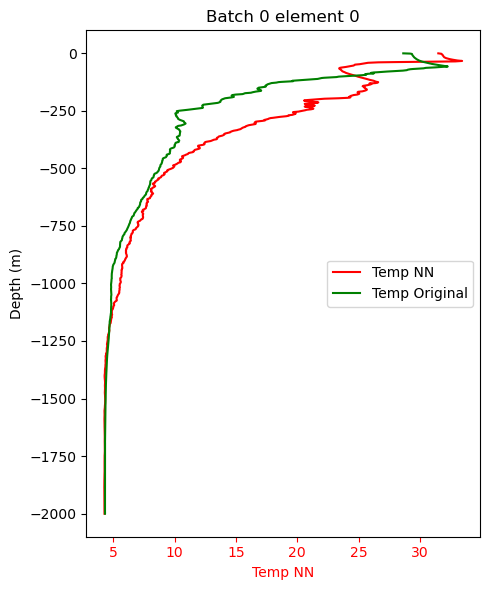

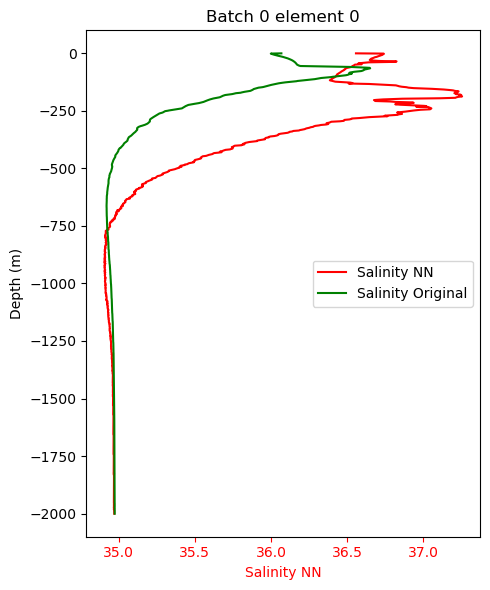

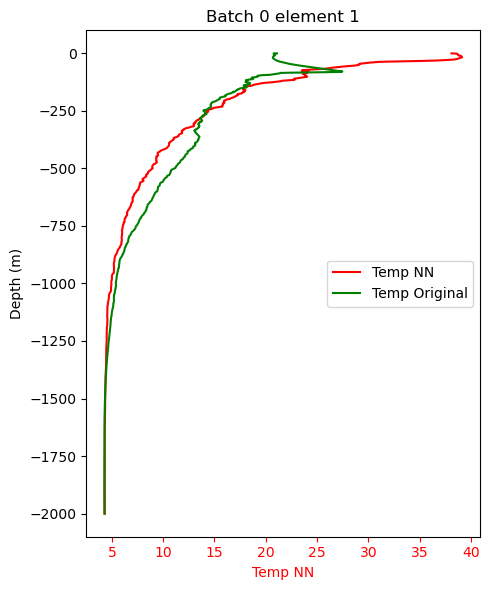

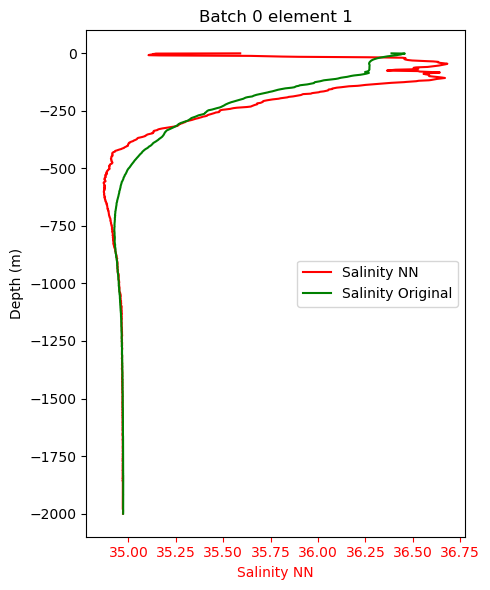

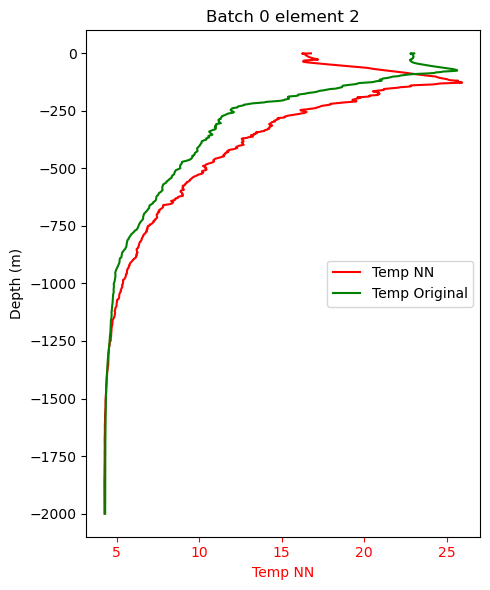

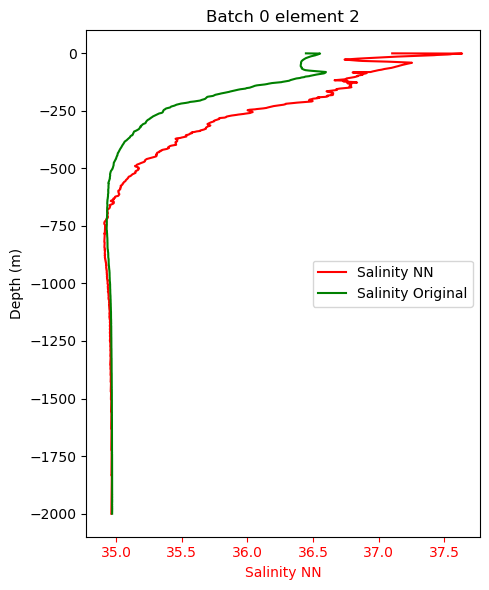

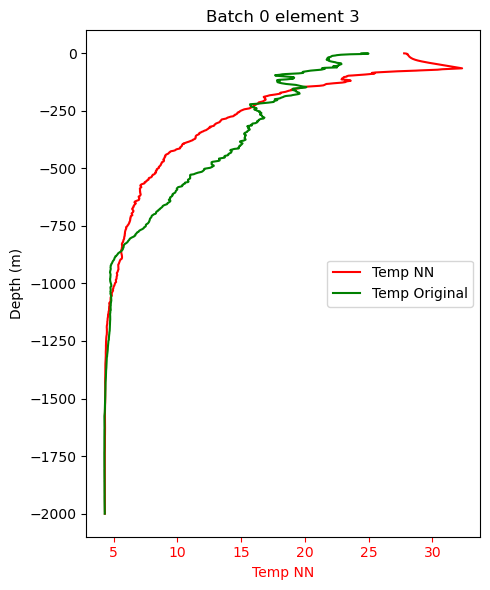

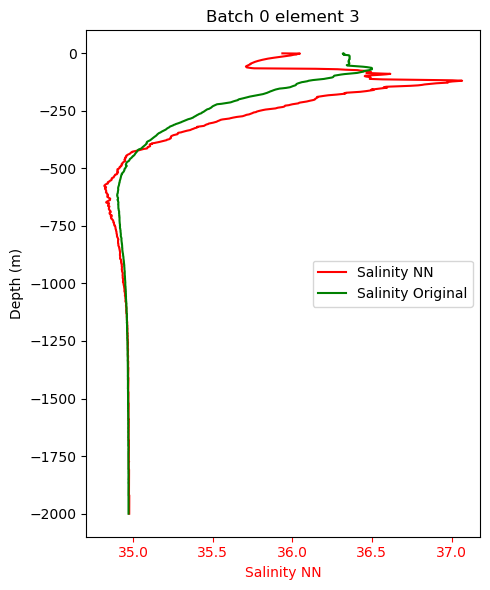

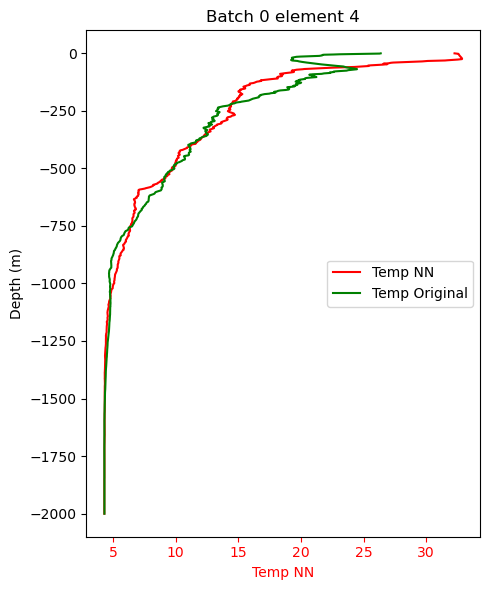

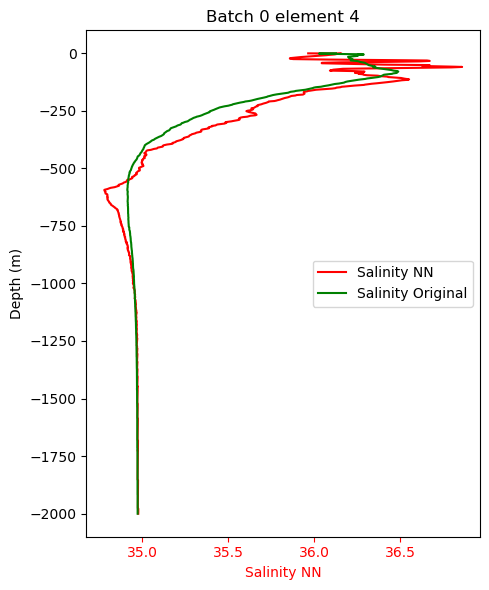

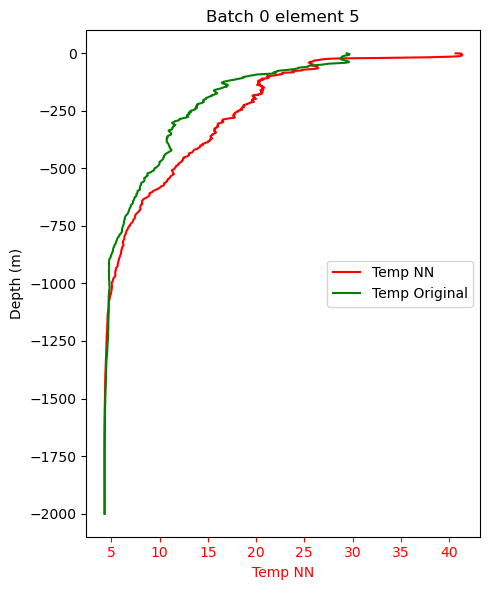

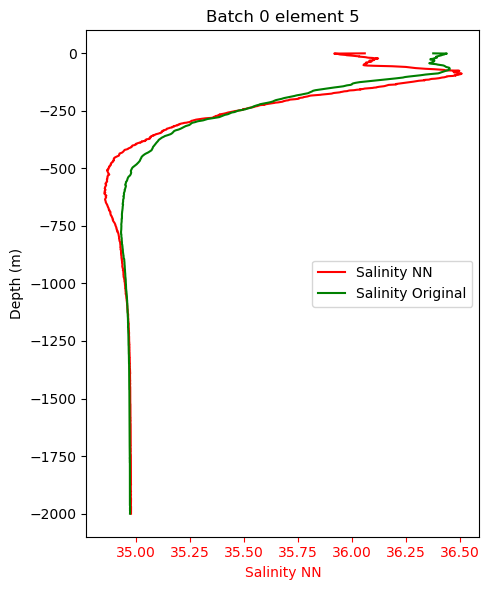

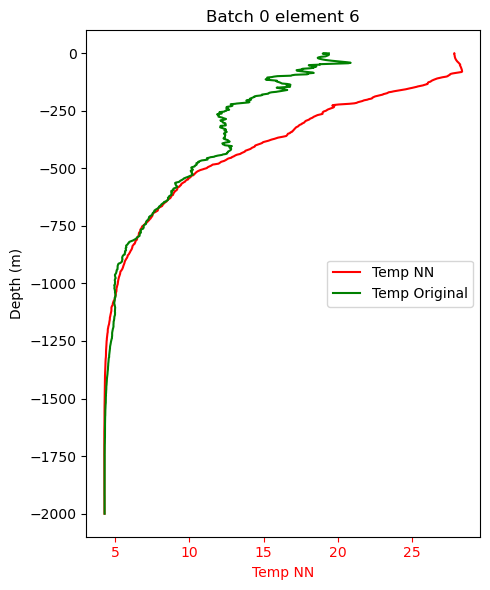

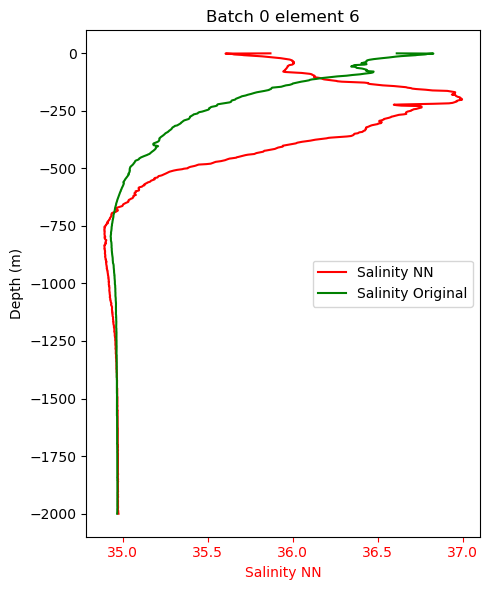

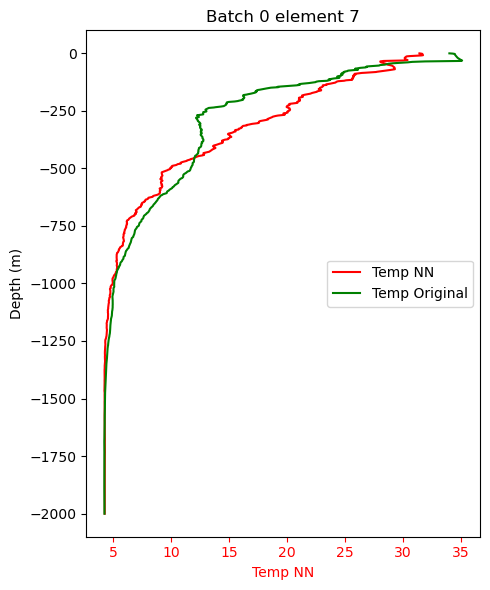

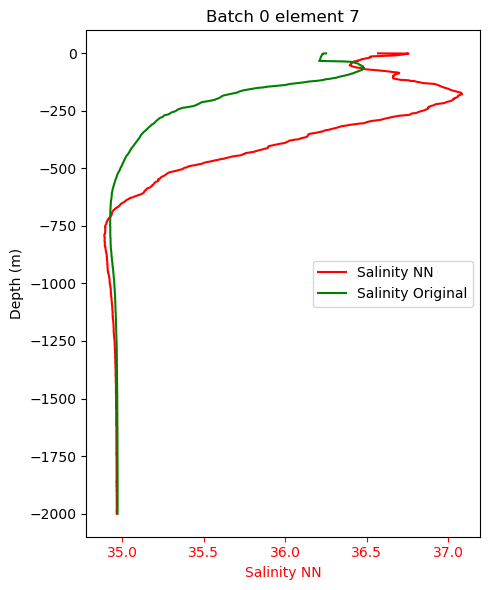

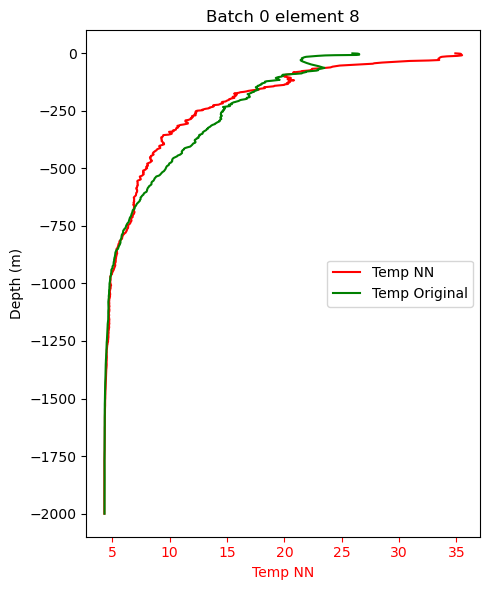

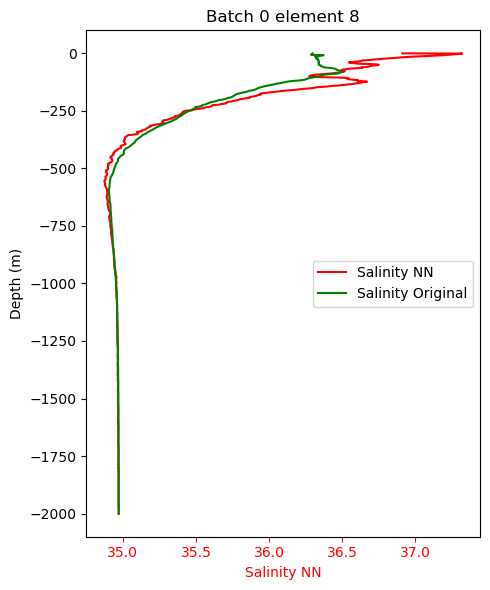

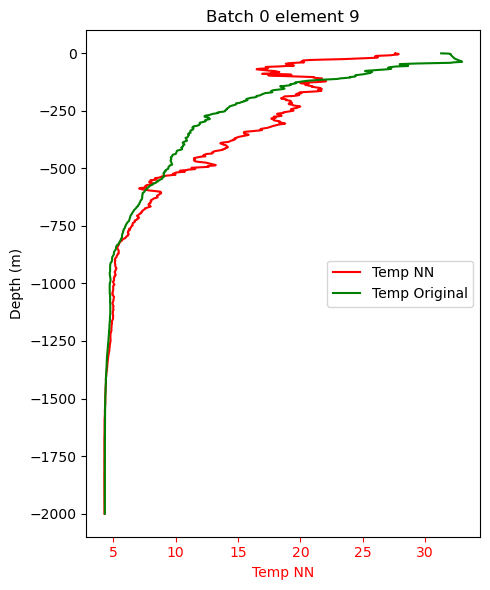

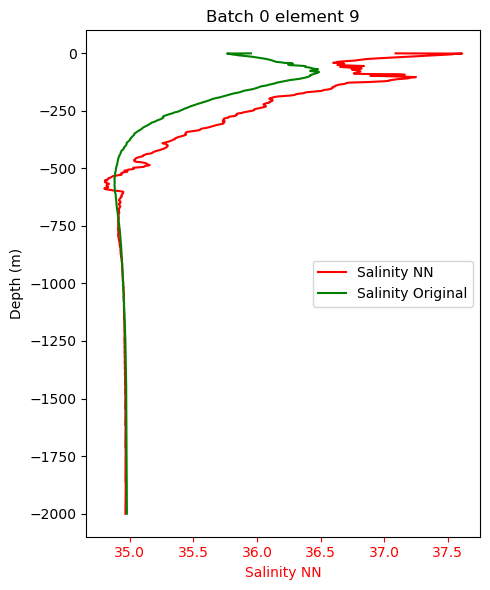

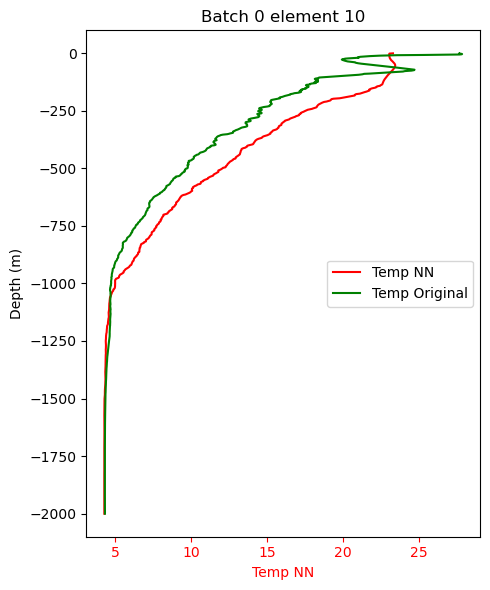

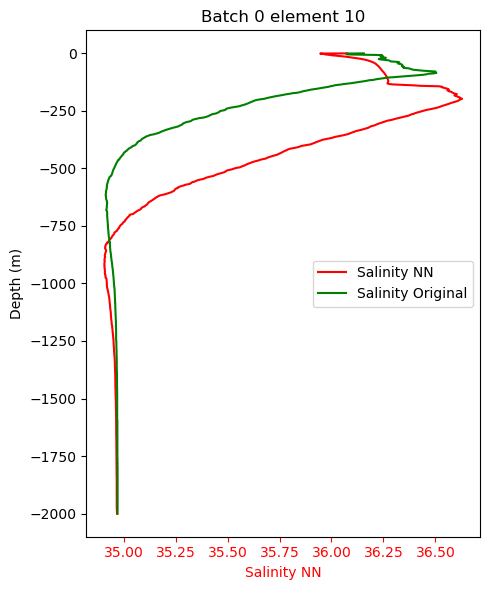

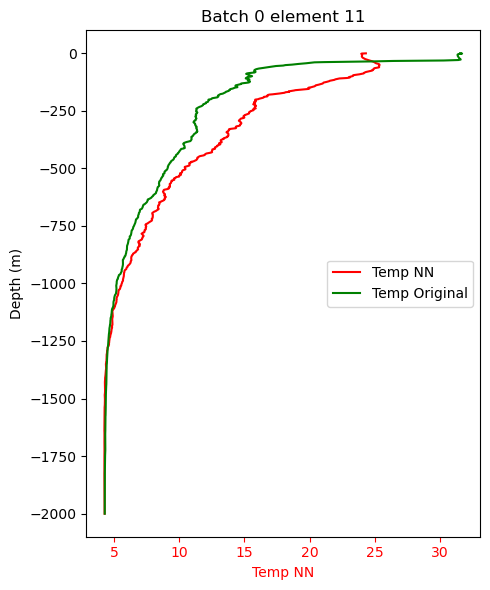

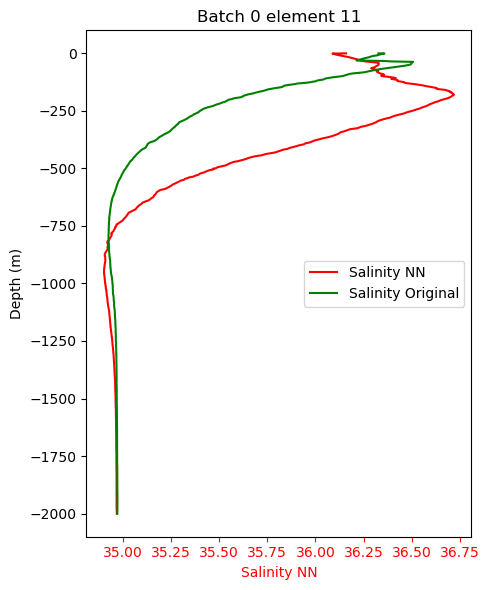

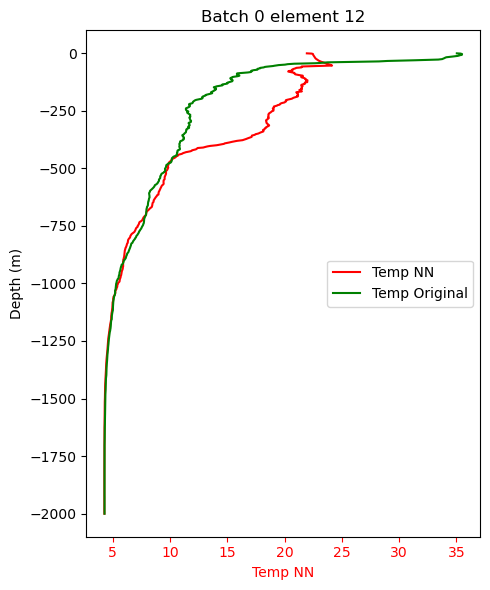

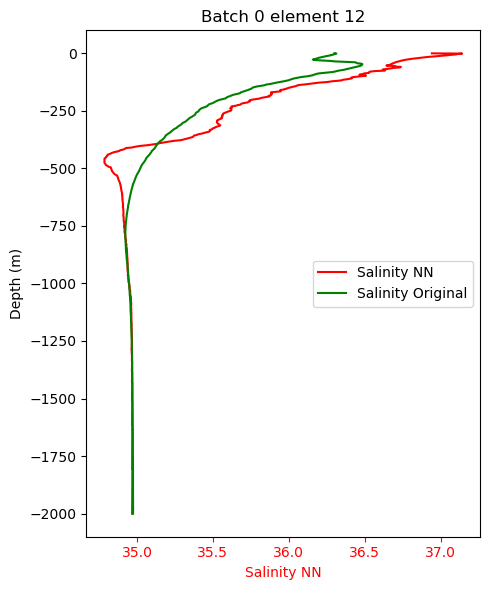

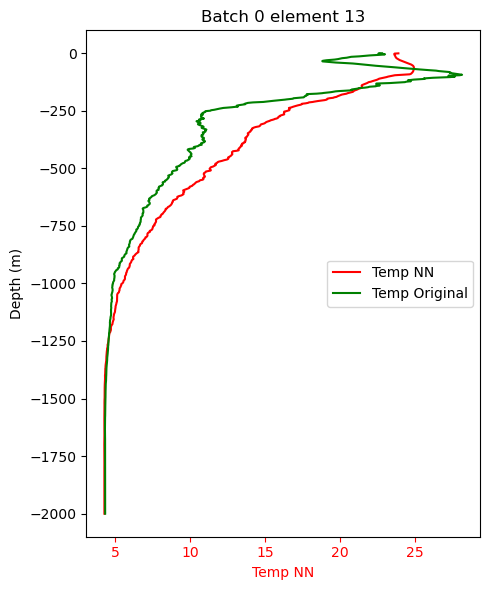

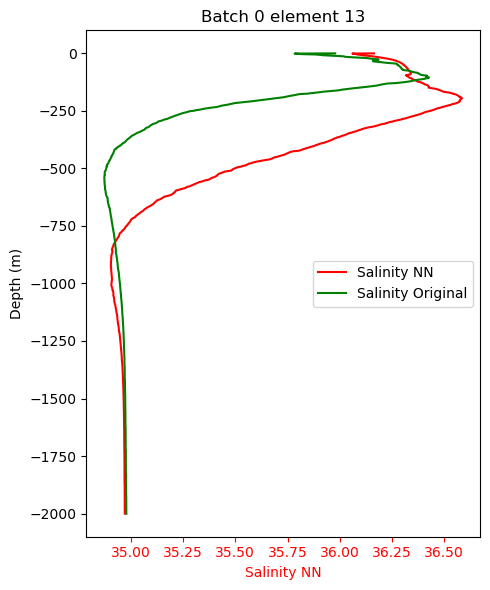

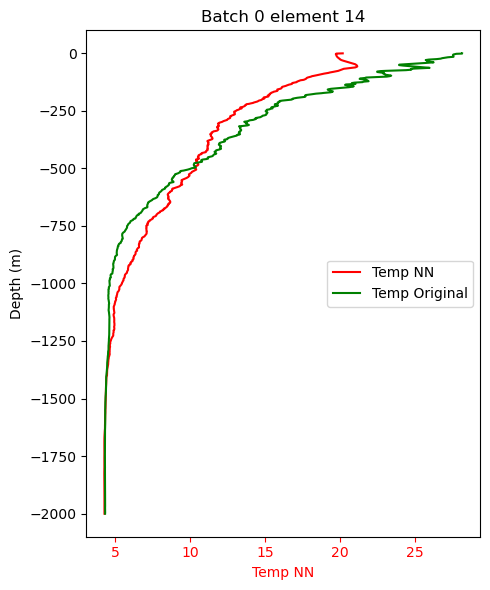

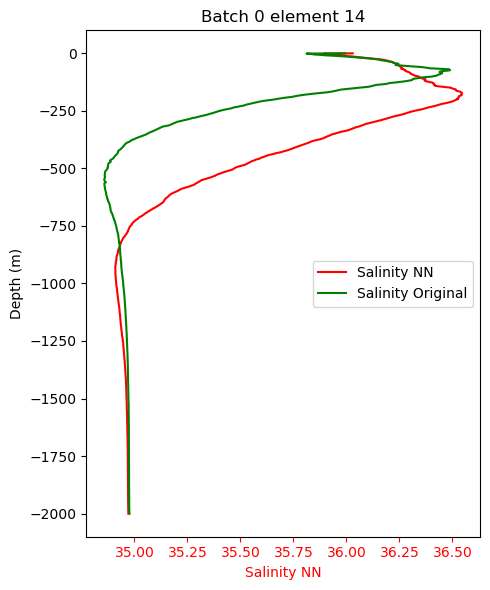

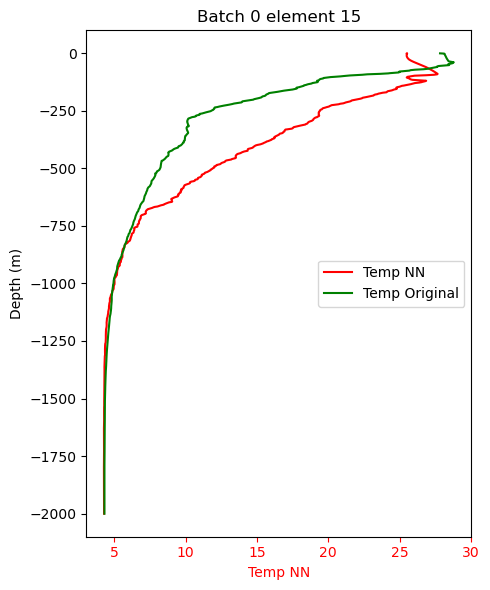

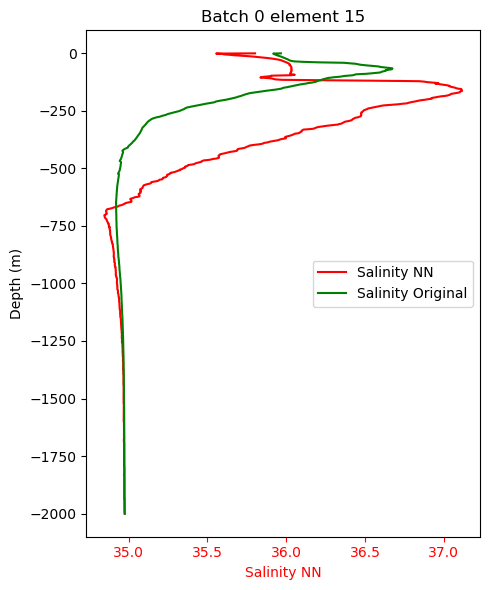

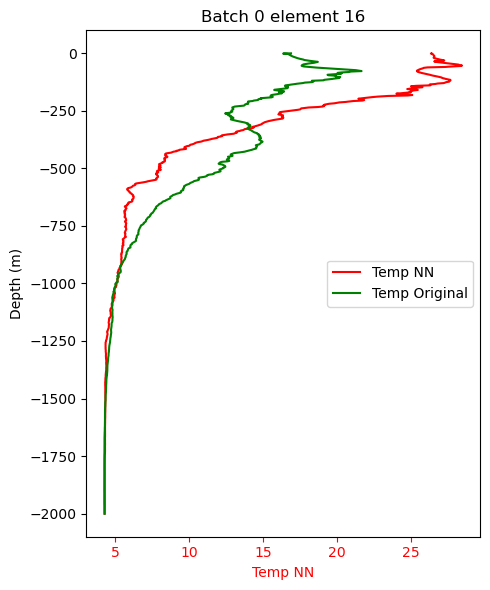

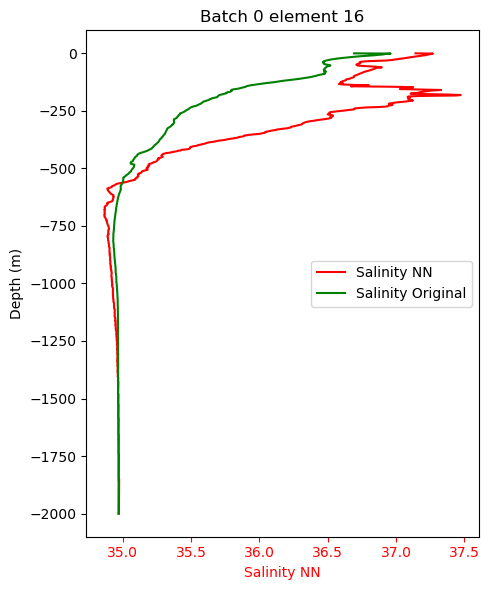

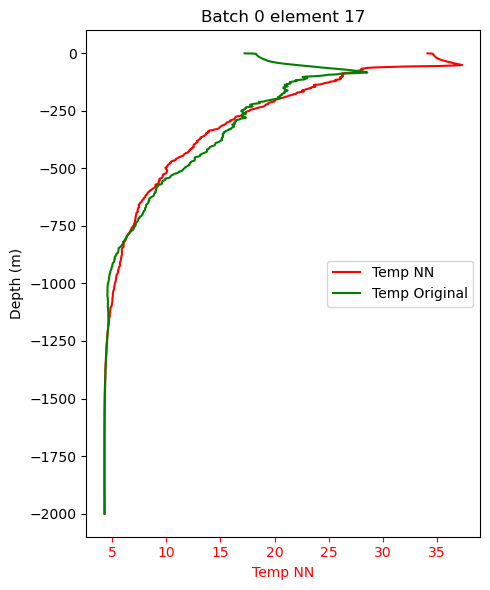

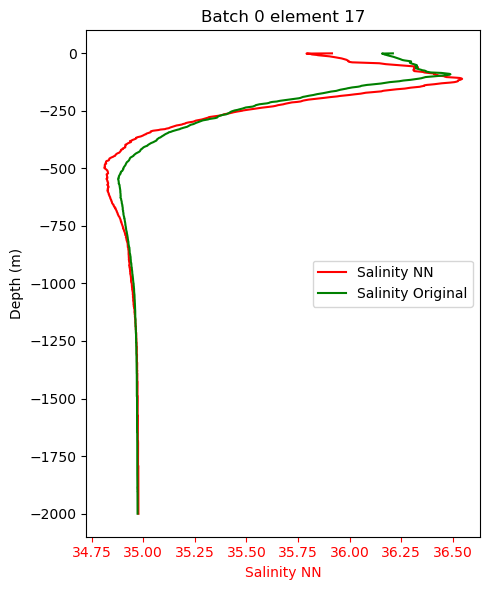

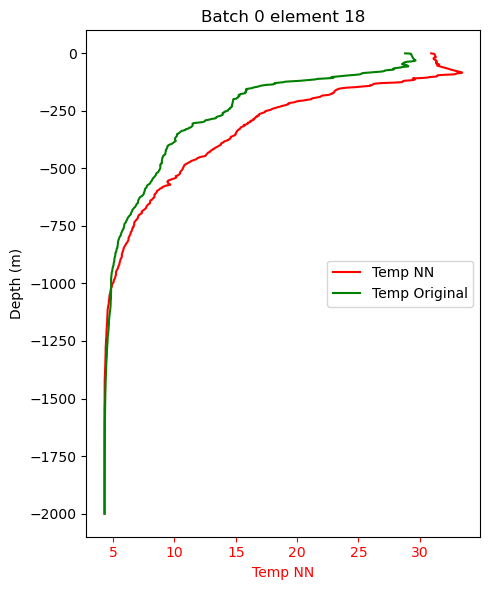

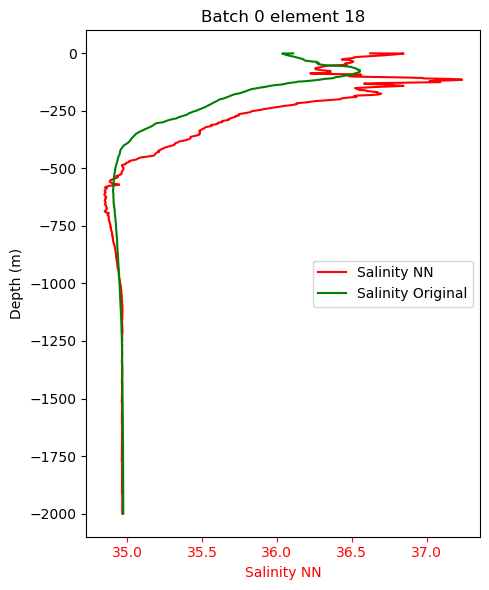

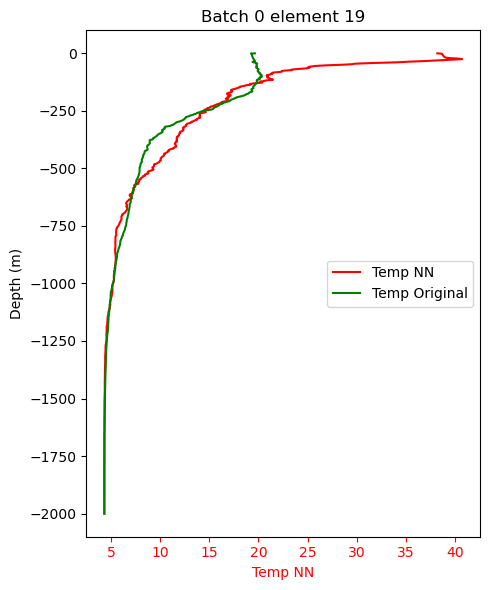

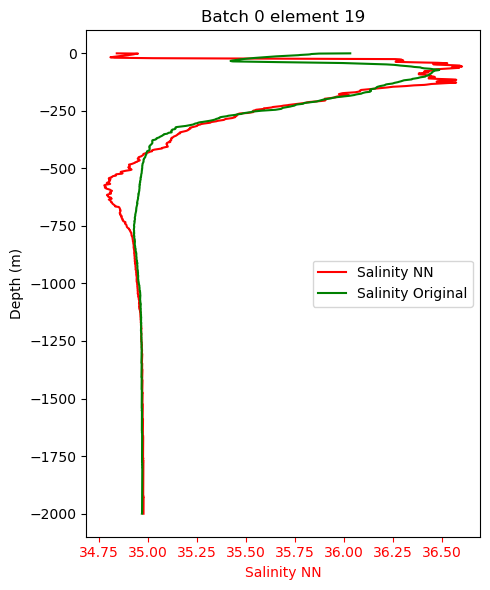

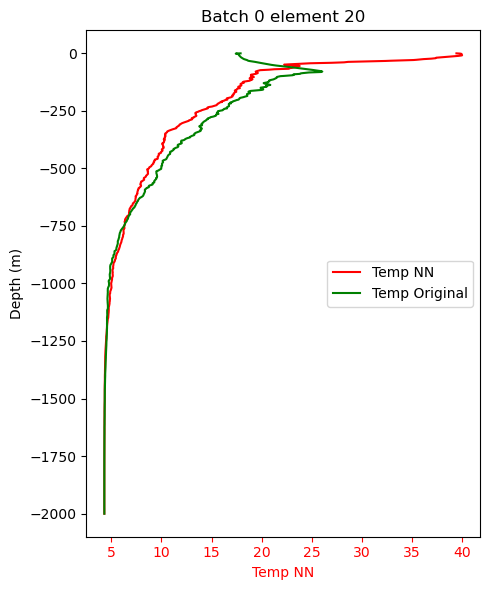

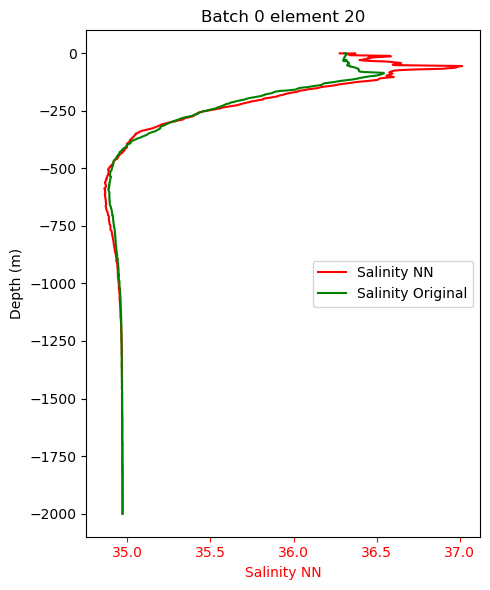

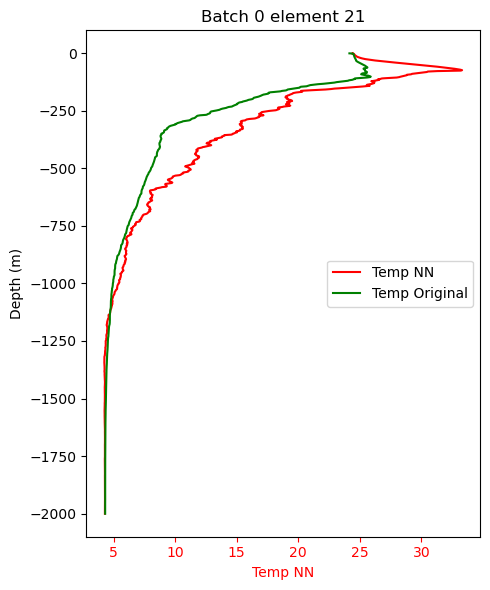

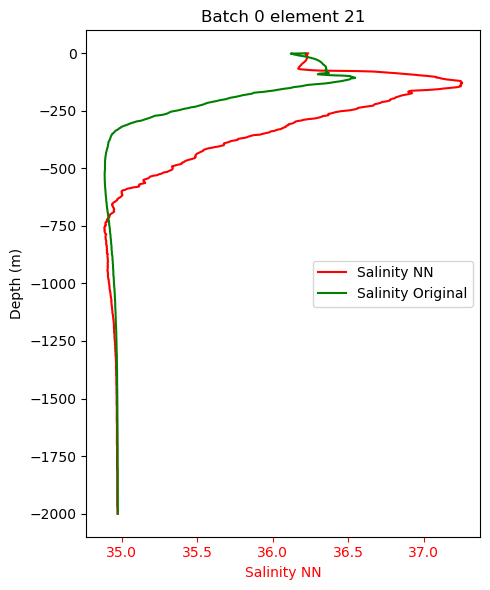

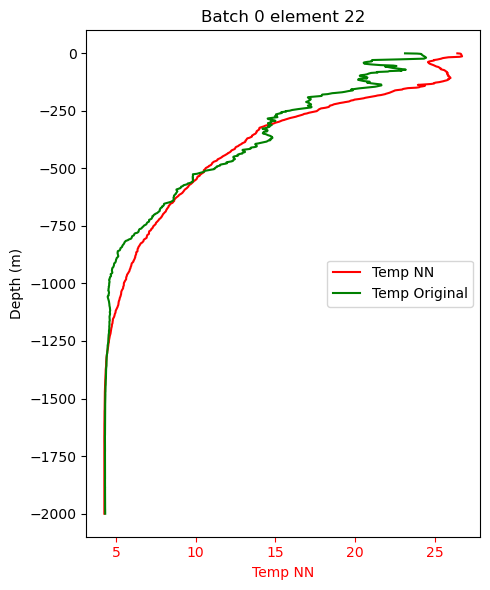

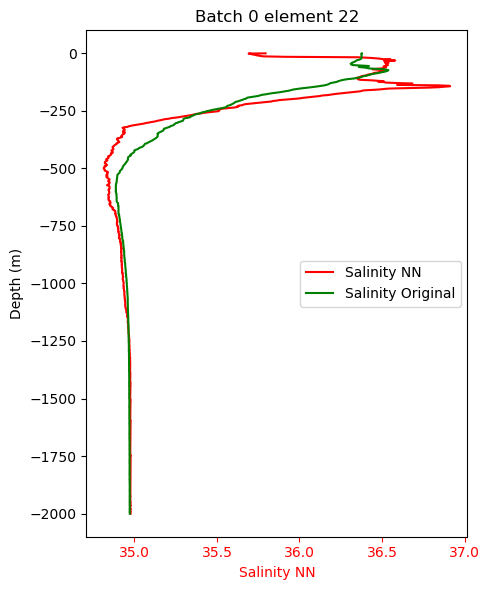

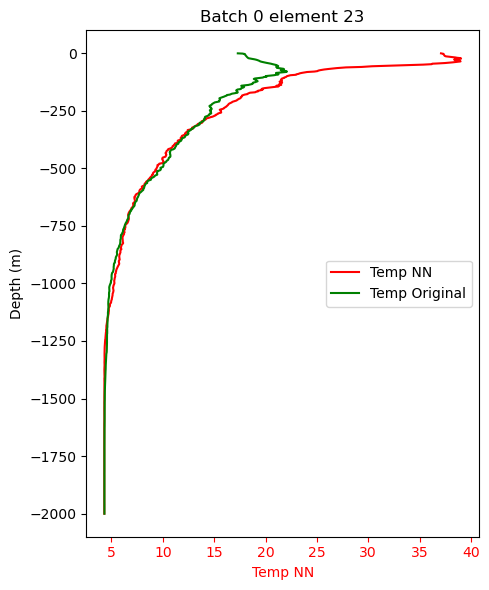

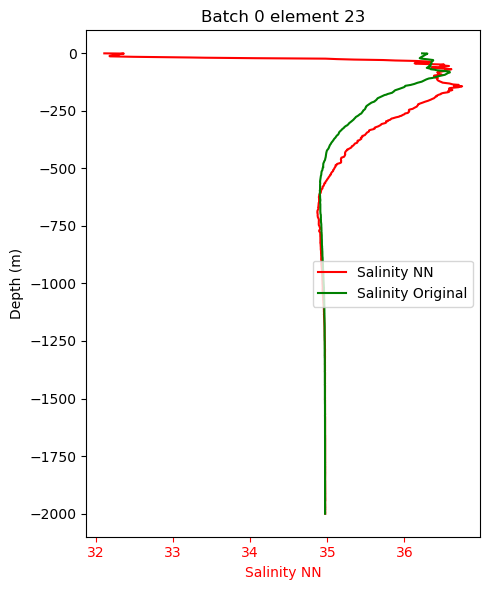

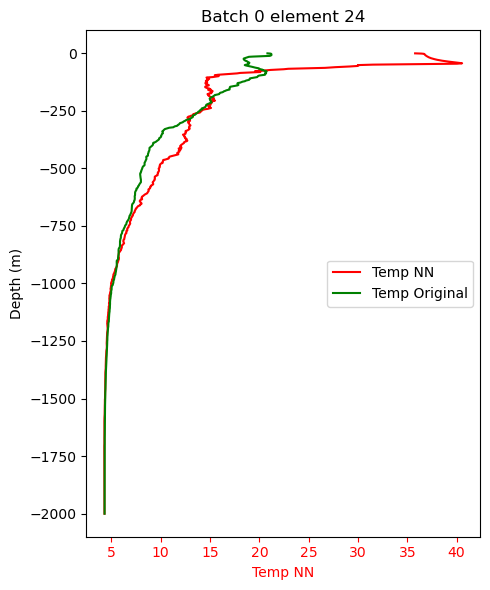

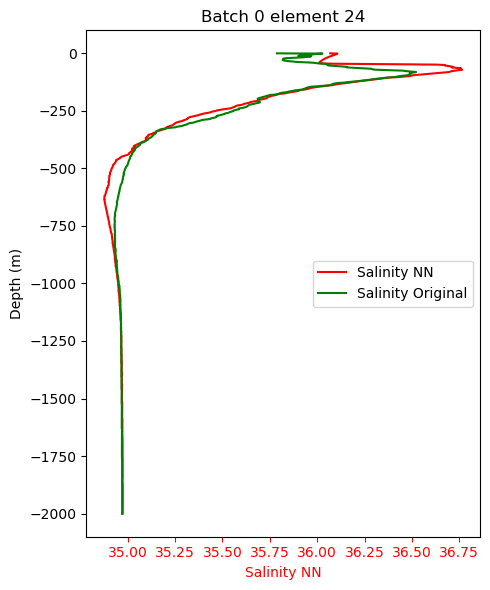

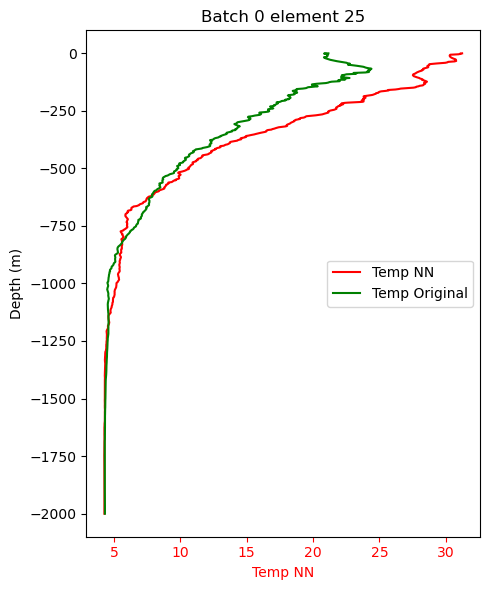

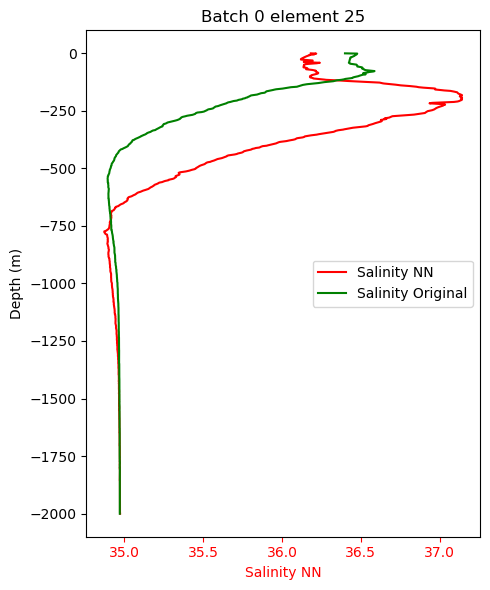

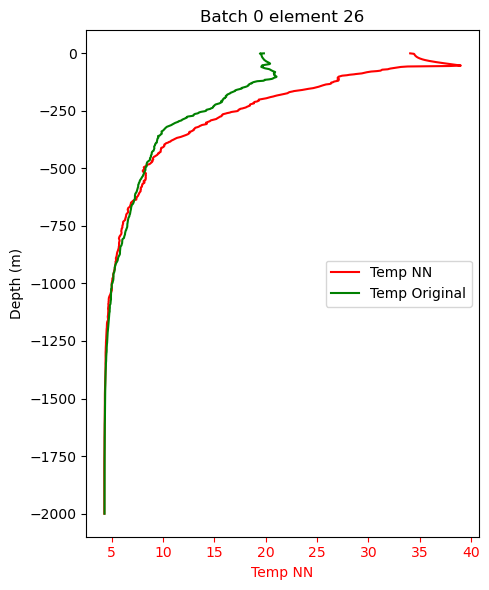

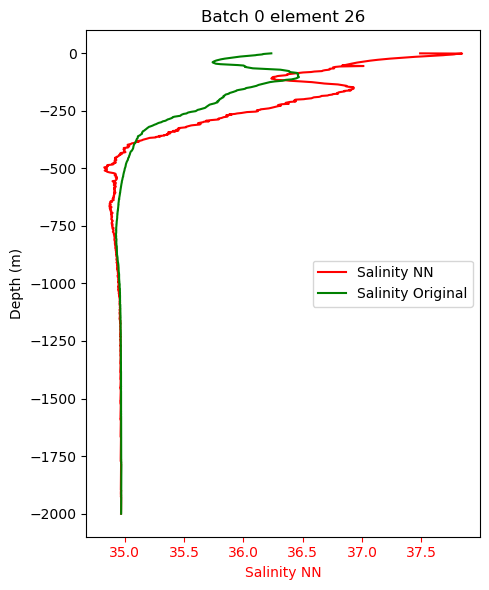

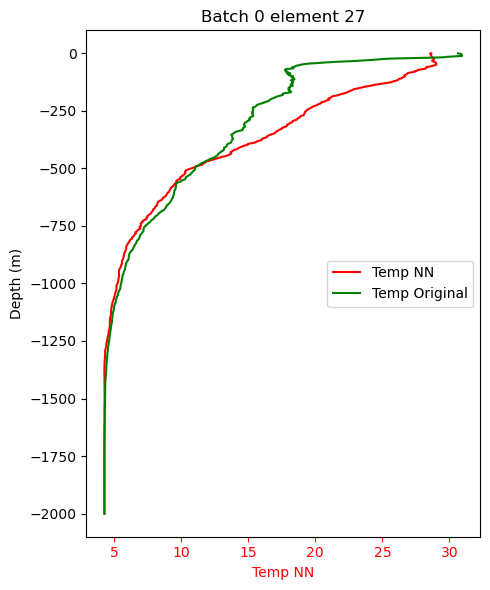

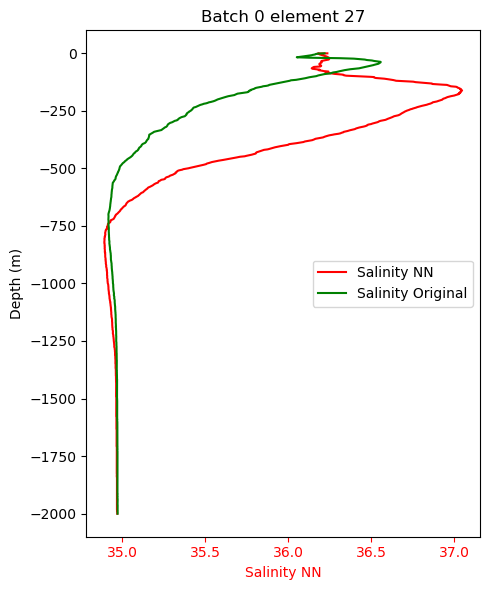

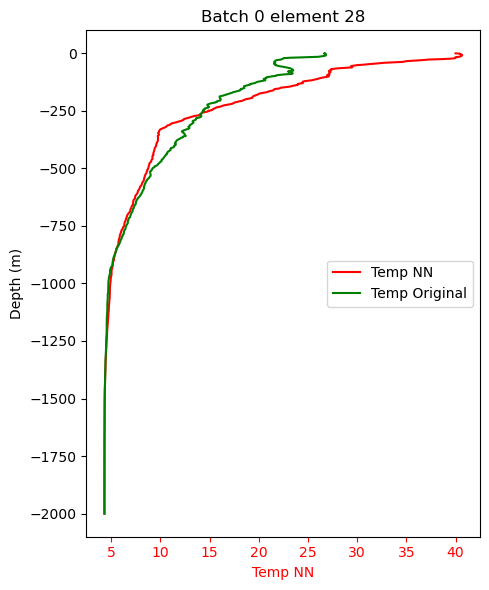

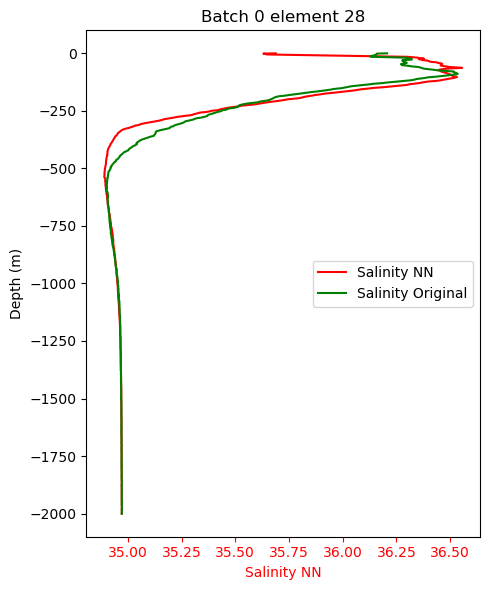

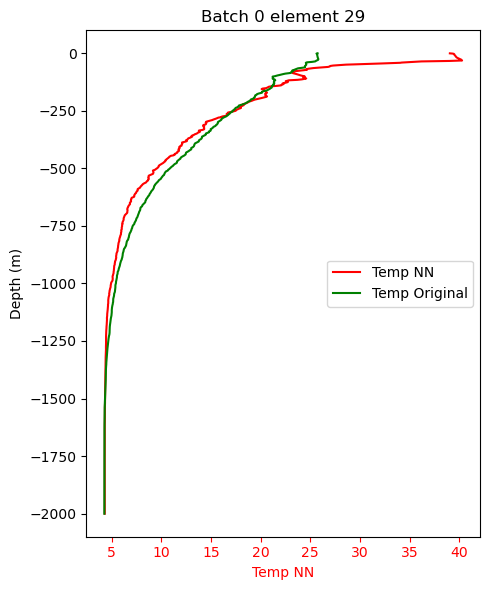

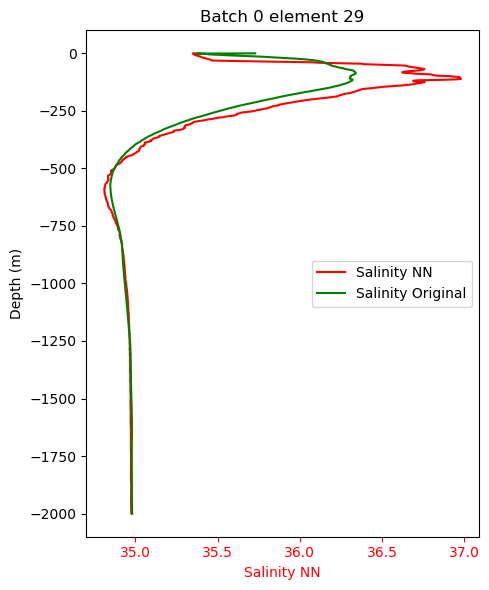

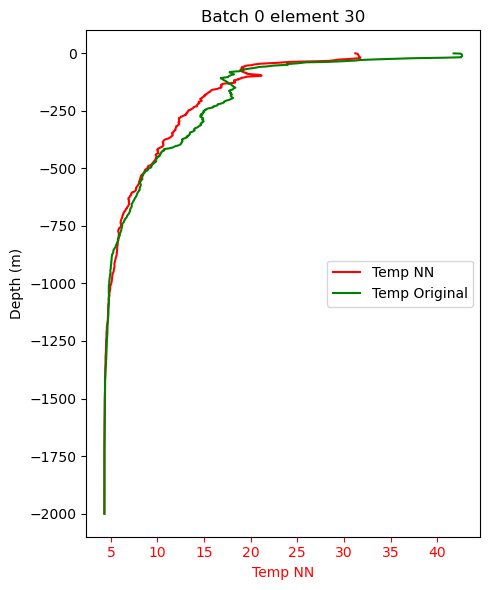

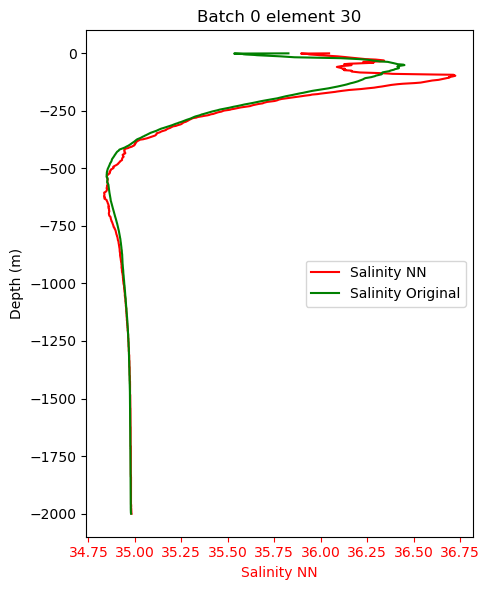

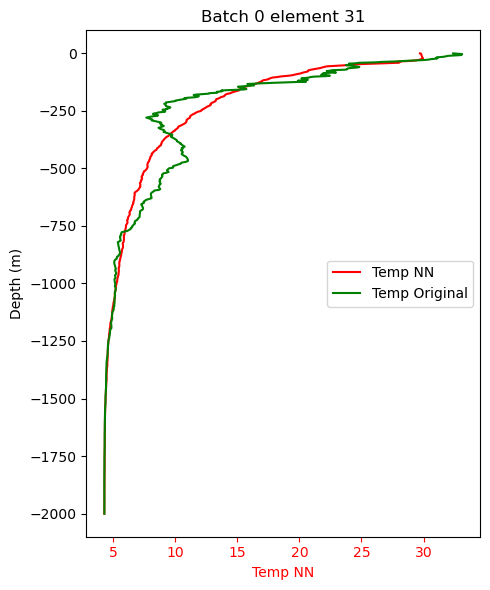

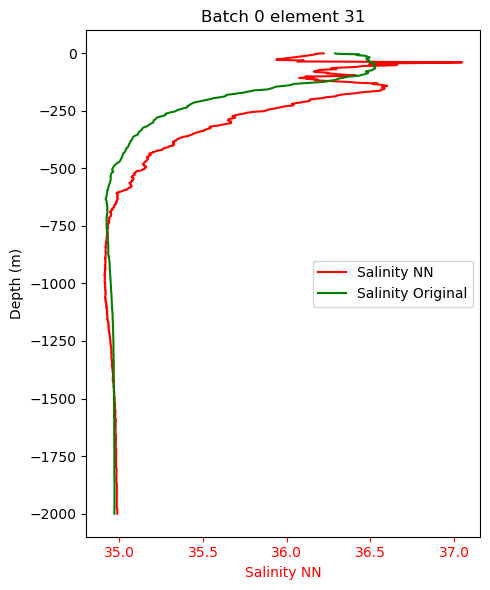

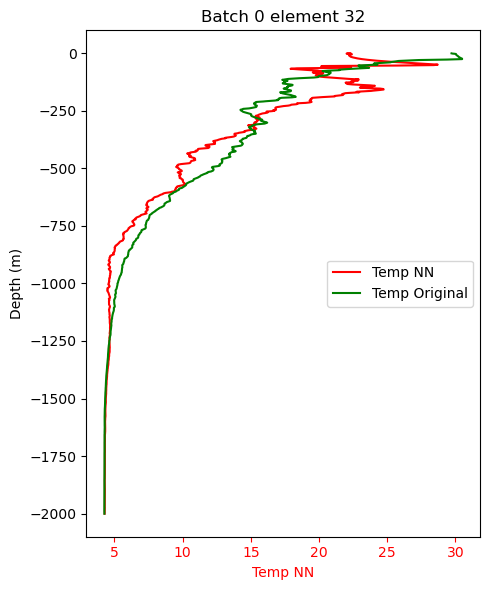

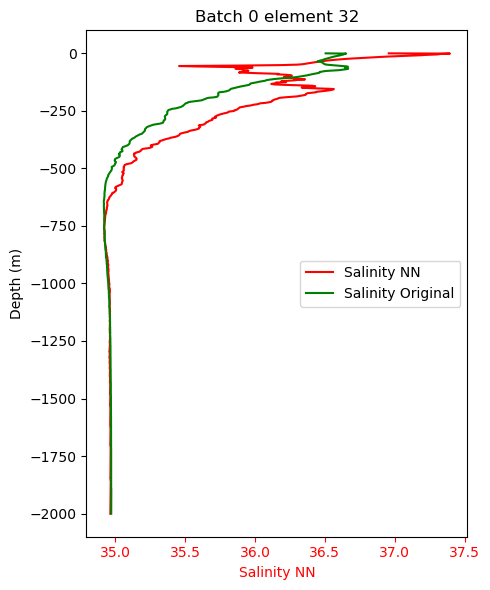

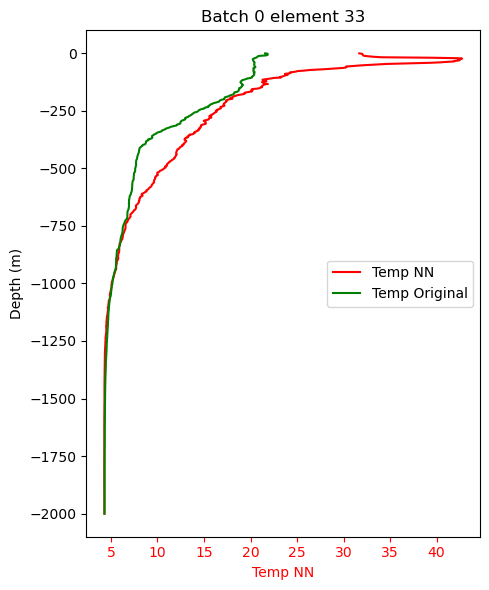

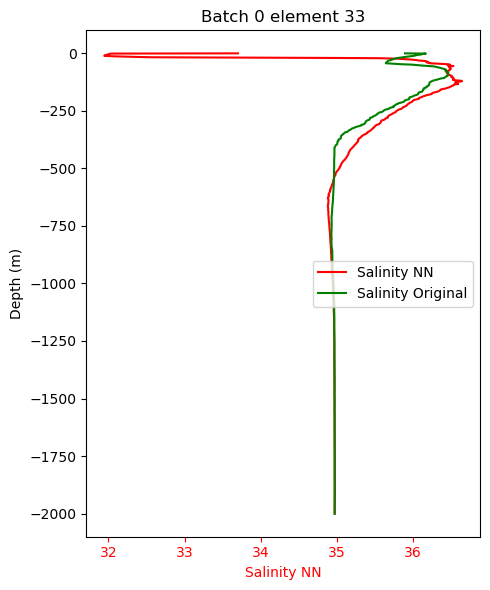

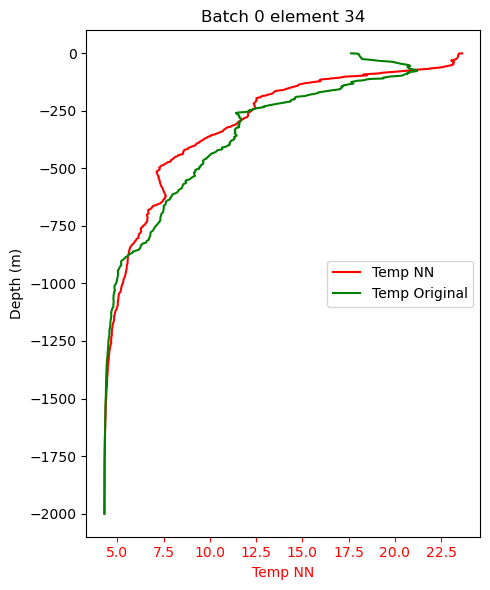

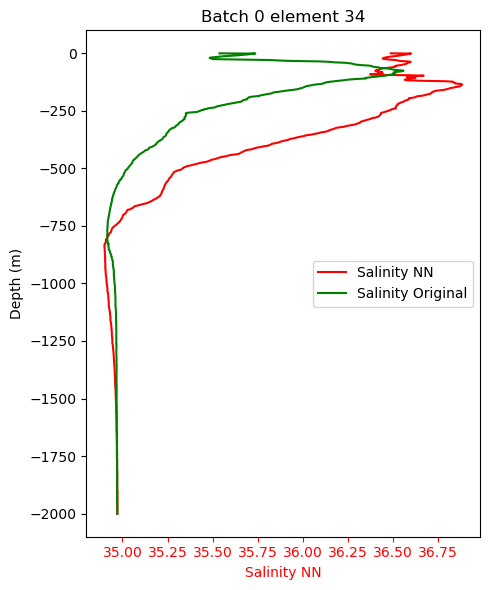

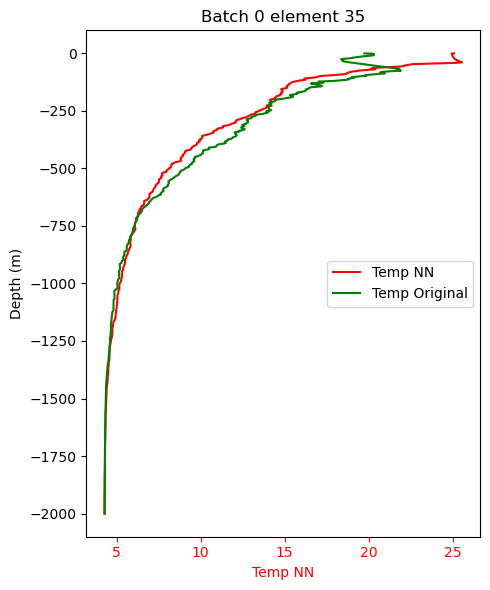

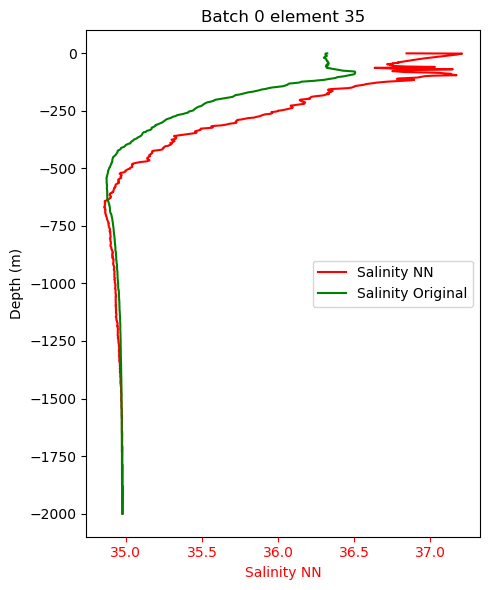

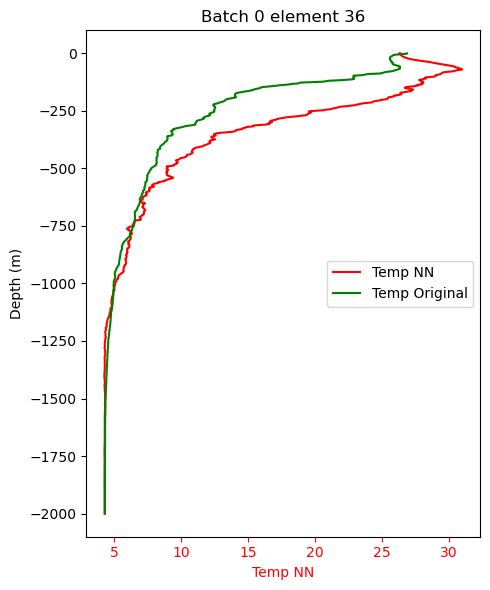

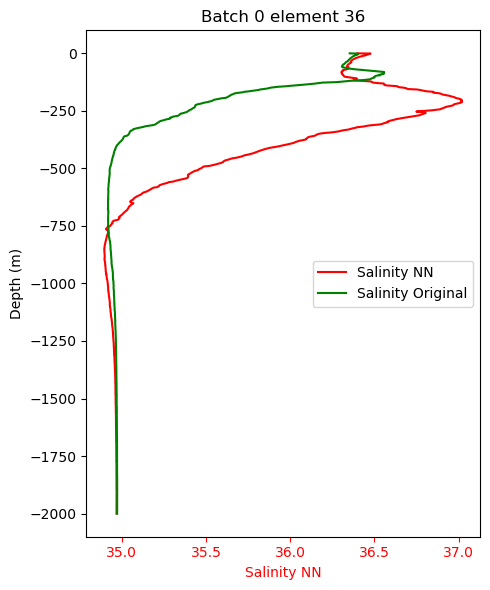

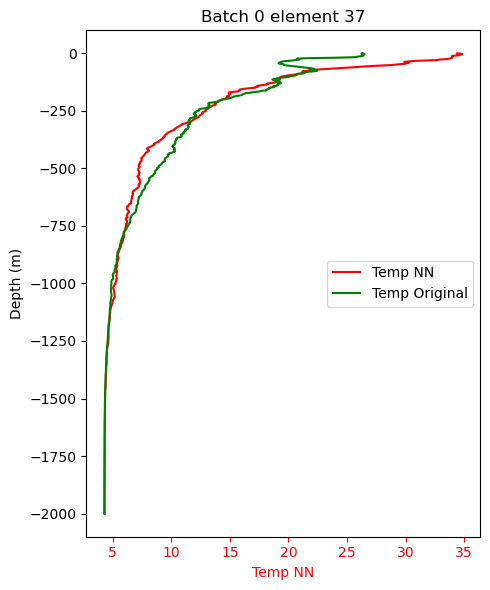

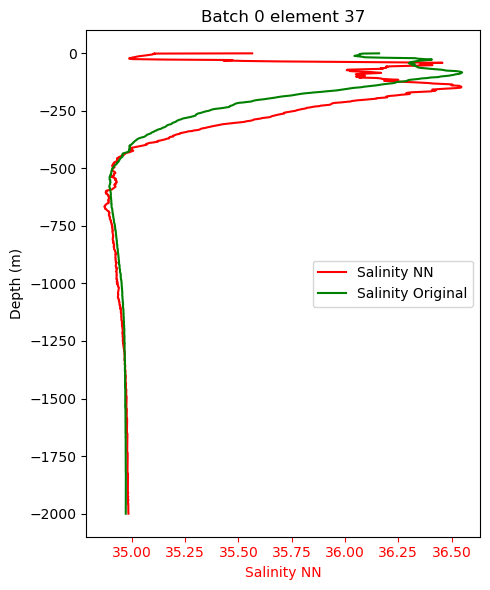

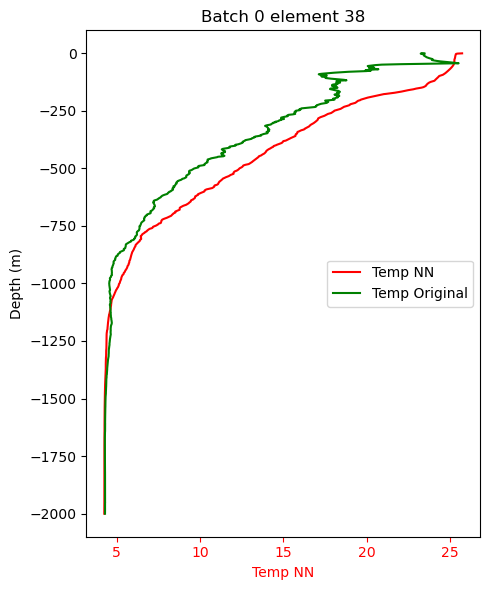

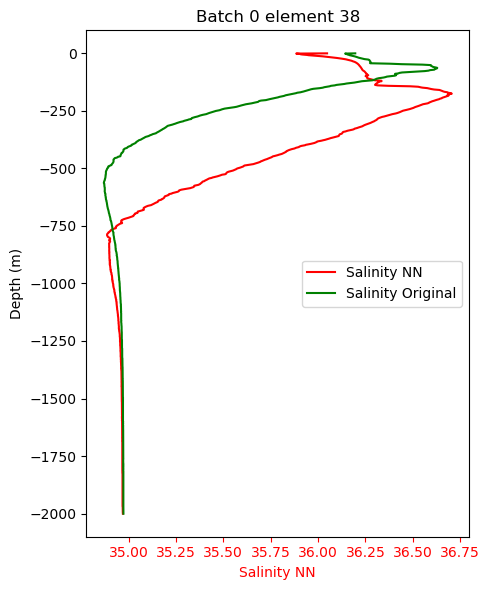

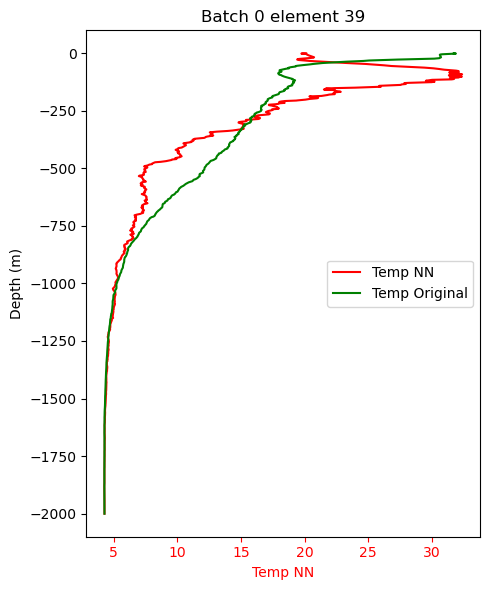

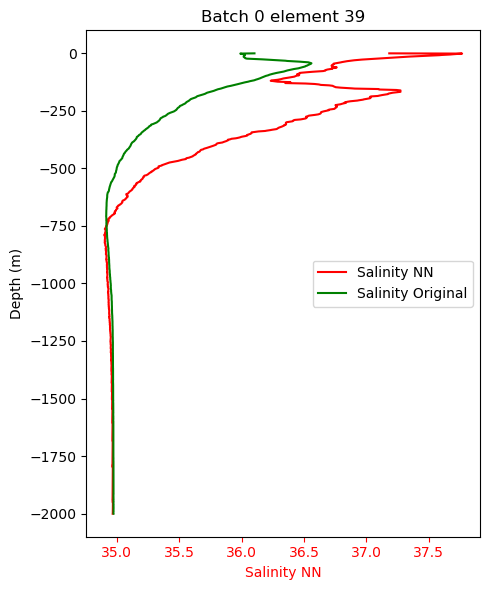

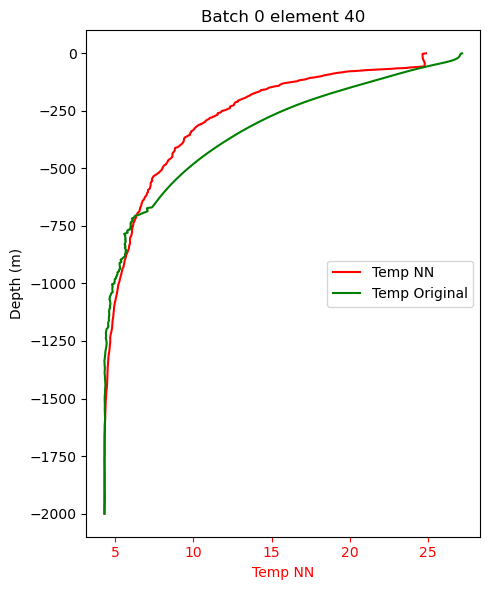

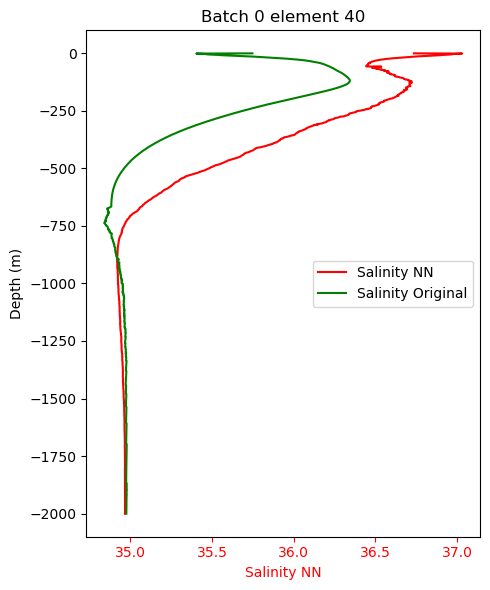

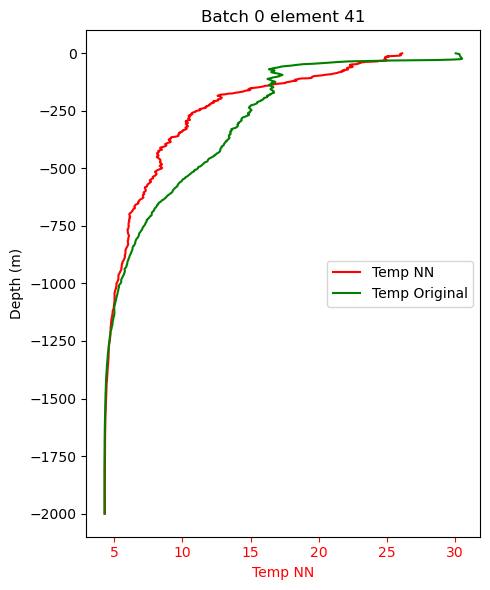

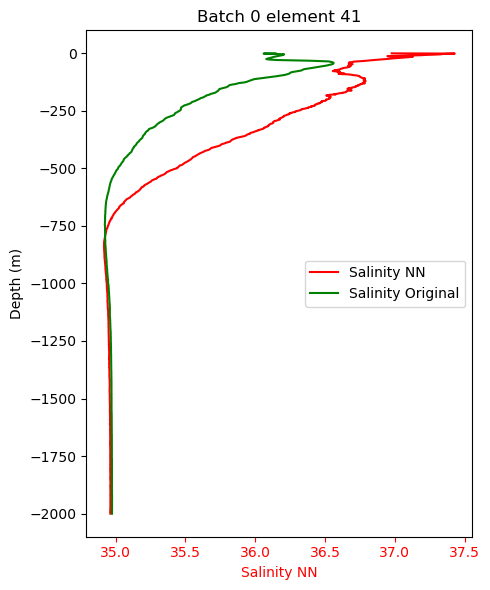

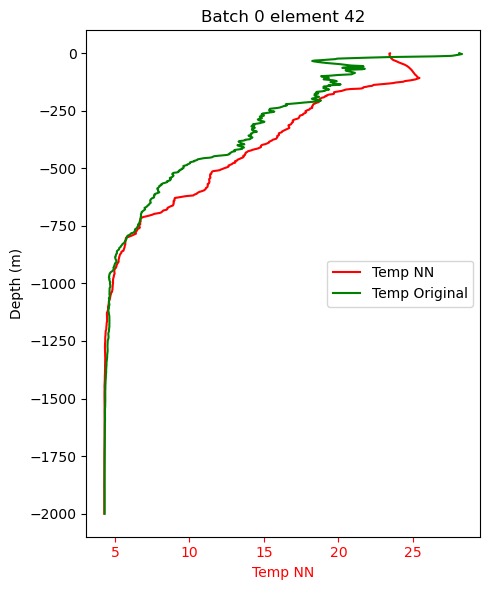

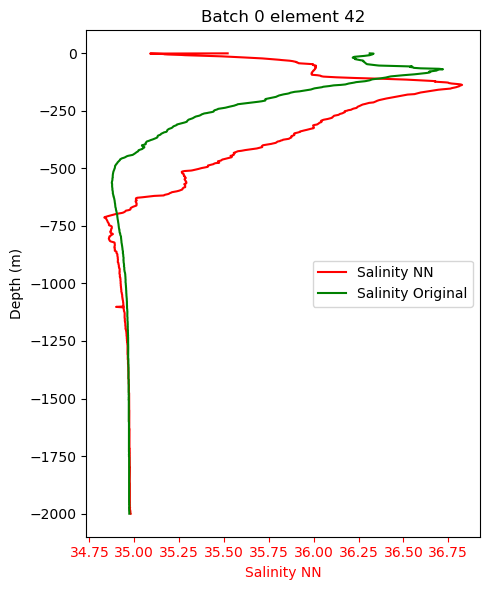

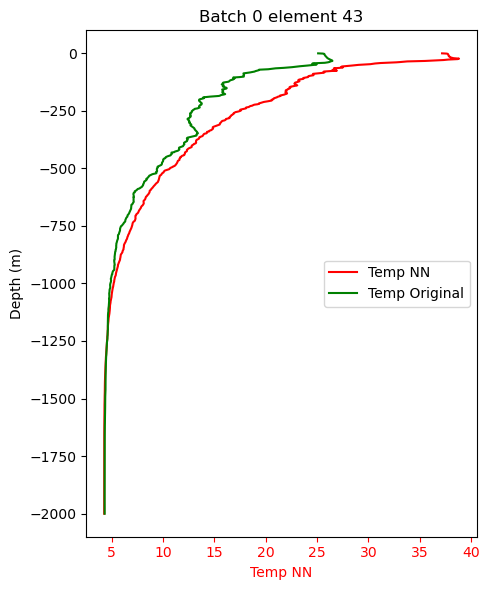

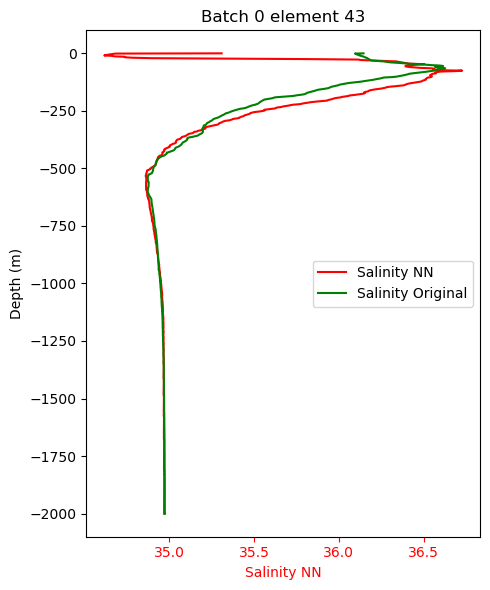

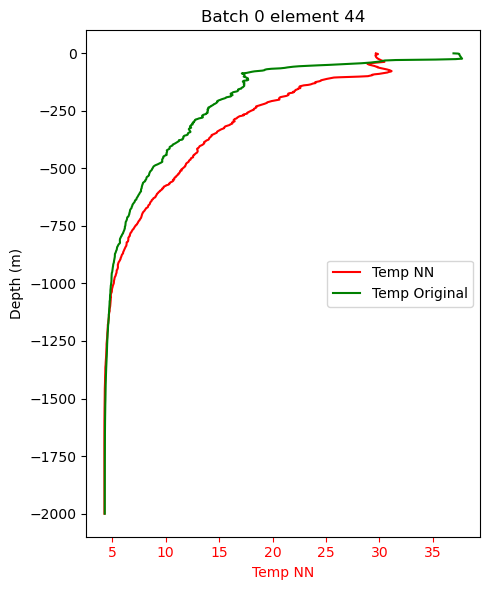

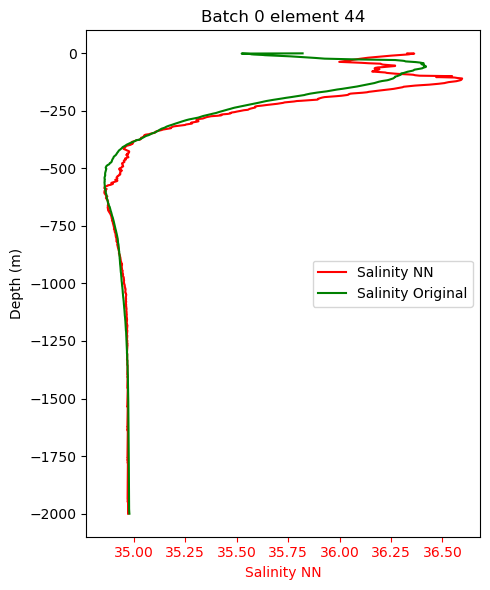

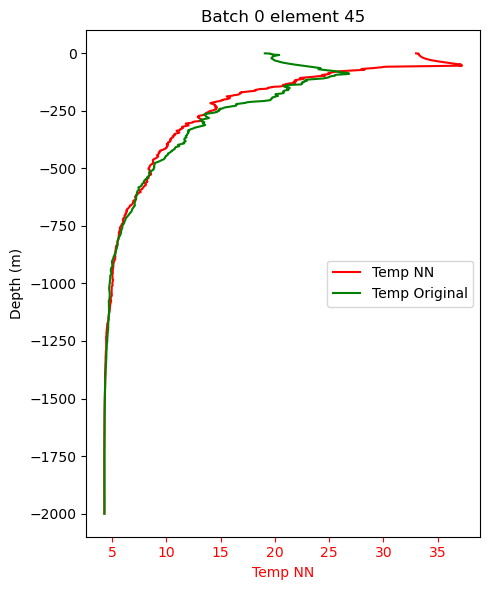

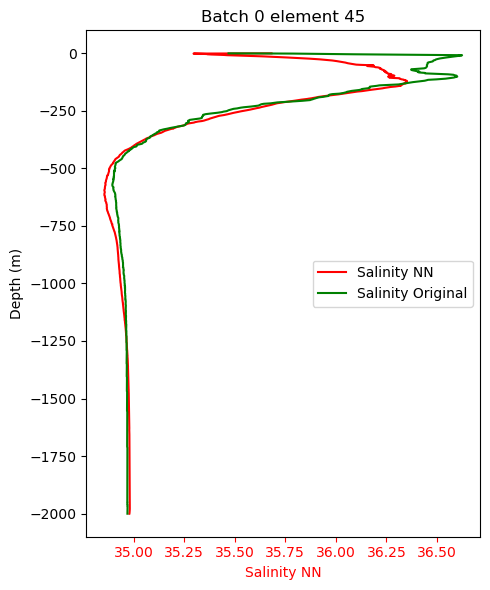

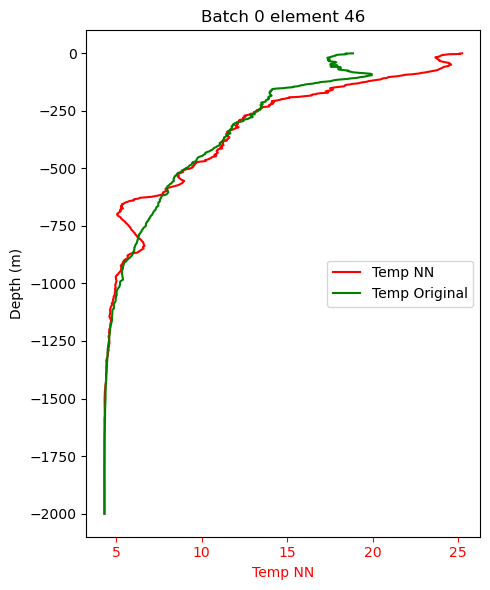

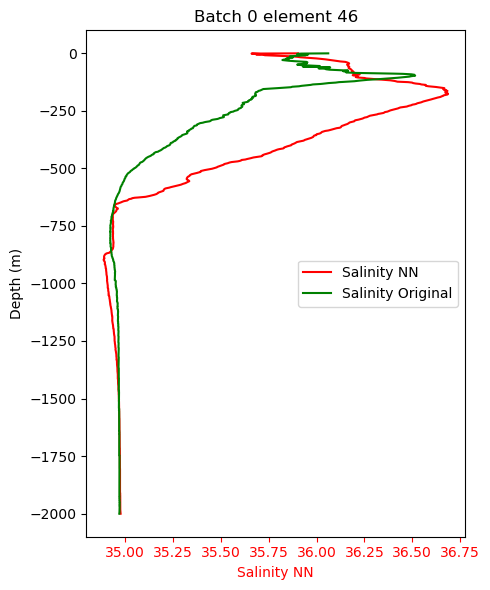

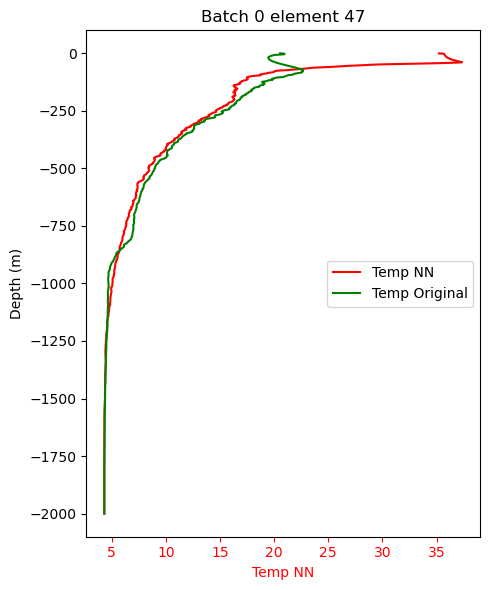

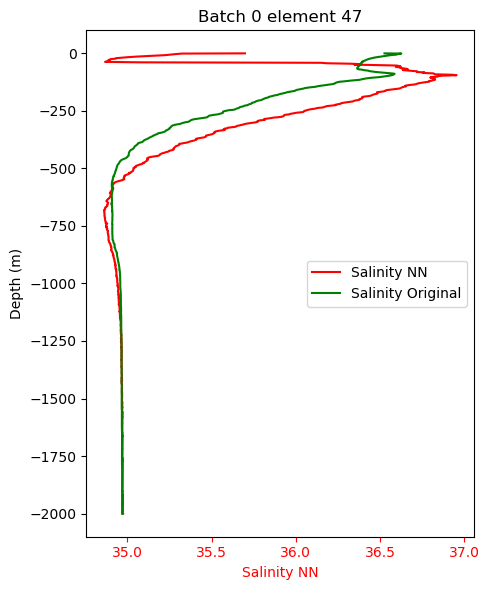

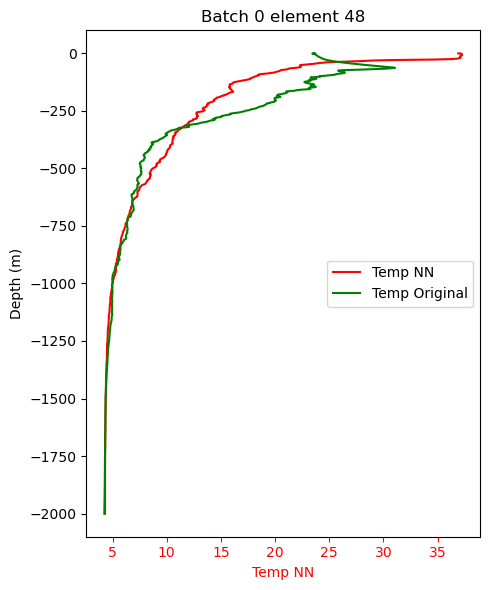

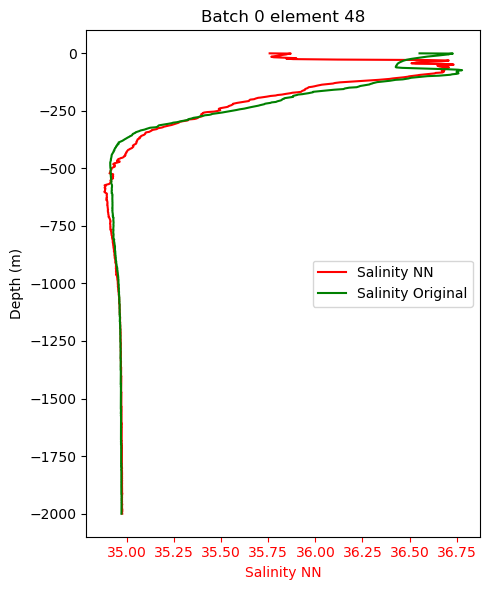

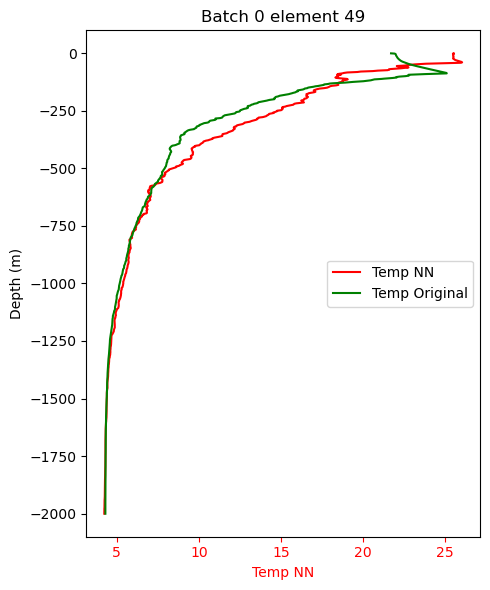

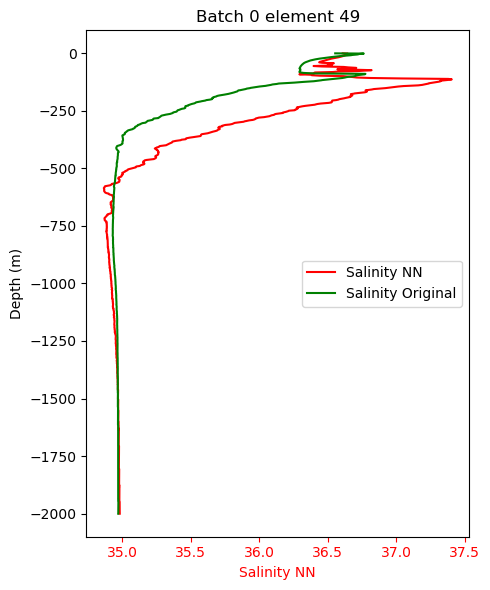

In [10]:
inoutdims = dataset.get_inout_dims()
if not with_pca:
    revert_normalization_test(dataset, with_pca, dataset.scaler)

for i, batch in enumerate(val_loader):
    # Print the size of the batch, size of input and output
    print(f'Batch size: {batch_size_training}, Input size: {batch[0].shape}, Output size: {batch[1].shape}')
    ssh, ts = batch
    for j in range(50):
    # for j in range(batch_size_training):
        temp_profile_original, sal_profile_original  = dataset.get_original_profile(i*batch_size_training+j)
        # temp_profile_original, sal_profile_original = revert_normalization_prof(temp_profile_original, sal_profile_original, data_folder, dataset.scaler)
        if with_pca:
            temp_profile, sal_profile  = dataset.inverse_pca(ts[j][0:temp_components], ts[j][temp_components:])
            temp_profile_original, sal_profile_original  = dataset.inverse_pca(temp_profile_original, sal_profile_original)
            # temp_profile, sal_profile = revert_normalization_prof(temp_profile, sal_profile, data_folder, dataset.scaler)
            name = 'PCA'
        else:
            temp_profile, sal_profile = ts[j][0:int(inoutdims[1]/2)], ts[j][int(inoutdims[1]/2):]
            # temp_profile, sal_profile = revert_normalization_prof(temp_profile, sal_profile, data_folder, dataset.scaler)
            name = 'NN'
                
        compare_profiles(temp_profile, temp_profile_original, title=f'Batch {i} element {j}', 
                            labelone="Temp " + name, labeltwo="Temp Original", figsize=5, same_parameter=True)

        compare_profiles(sal_profile, sal_profile_original, title=f'Batch {i} element {j}', 
                            labelone="Salinity " + name, labeltwo="Salinity Original", figsize=5, same_parameter=True)
    break

In [11]:
batch

[tensor([[ 0.8128,     nan,  0.1695],
         [-0.8285,     nan,  0.4267],
         [-0.6338,     nan,  0.9998],
         ...,
         [-1.0477,     nan,  0.6385],
         [ 0.7237,     nan,  0.6747],
         [ 0.8527,     nan, -0.2135]]),
 tensor([[    nan, 31.4952, 31.6532,  ..., 34.9708, 34.9709, 34.9708],
         [    nan, 38.1047, 38.5745,  ..., 34.9717, 34.9716, 34.9715],
         [    nan, 16.7809, 16.2446,  ..., 34.9644, 34.9641, 34.9635],
         ...,
         [    nan, 23.2598, 23.1540,  ..., 34.9748, 34.9750, 34.9751],
         [    nan, 31.0837, 31.2223,  ..., 34.9645, 34.9641, 34.9638],
         [    nan, 25.8024, 25.3850,  ..., 34.9695, 34.9694, 34.9694]])]

In [12]:
val_loader